# Trabajo práctico integrador - Aprendizaje de Máquina I

## Carrera de Especialización en Inteligencia Artificial / 23Co2025

### Alumnos:

* Paola Andrea Blanco     **(a2303)**
* Facundo Manuel Quiroga  **(a2305)**
* Juan Manuel Fajardo     **(a2310)**
* Victor Gabriel Peralta  **(a2322)**
* Agustín Jesús Vazquez   **(e2301)**

## 1. Introducción y objetivo de trabajo

**Fuente de información de evaluación:** Utilizaremos el dataset [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package), el cual comprende aproximadamente 10 años de observaciones diarias del clima en numerosos lugares de Australia.

**Objetivo:** Queremos predecir si lloverá o no al día siguiente en función de datos meteorológicos del día actual, para integrar esta información en una aplicación meteorológica que beneficie al público.

In [45]:
# Importamos librerías necesarias para el desarrollo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)  # Mostrar todas las columnas al imprimir un DataFrame

## 2. Carga de datos y análisis exploratorio (EDA)

En esta sección cargamos el conjunto de datos original y realizamos un breve análisis exploratorio para entender su estructura, distribuciones y valores faltantes.

In [23]:
# Cargar dataset
df = pd.read_csv('dataset/weatherAUS.csv')

In [4]:
# Dimensiones del DataFrame
print("Dimensiones del DataFrame:", df.shape)

Dimensiones del DataFrame: (145460, 23)


In [31]:
df.info()  # Tipos de datos de cada columna

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Análisis Missing

In [58]:
# function to display missing values
def display_missing_values(dataframe):
     missing = dataframe.isnull().sum()
     missing = missing[missing > 0]
     missing_percentage = (missing / len(dataframe)) * 100
     missing_df = pd.DataFrame({'missing_count': missing, 'missing_percentage': missing_percentage})
     return missing_df.sort_values(by='missing_percentage', ascending=False)

# Mostrar valores faltantes
missing_values = display_missing_values(df)
print("Valores faltantes en el DataFrame:\n", missing_values)

Valores faltantes en el DataFrame:
                missing_count  missing_percentage
Sunshine               69835           48.009762
Evaporation            62790           43.166506
Cloud3pm               59358           40.807095
Cloud9am               55888           38.421559
Pressure9am            15065           10.356799
Pressure3pm            15028           10.331363
WindDir9am             10566            7.263853
WindGustDir            10326            7.098859
WindGustSpeed          10263            7.055548
Humidity3pm             4507            3.098446
WindDir3pm              4228            2.906641
Temp3pm                 3609            2.481094
RainTomorrow            3267            2.245978
Rainfall                3261            2.241853
RainToday               3261            2.241853
WindSpeed3pm            3062            2.105046
Humidity9am             2654            1.824557
Temp9am                 1767            1.214767
WindSpeed9am            1767     

Tenemos 4 features con más de 30% de missings que serían candidatas a ser dropeadas:
* Sunshine 48%, Evaporation 43%, Cloud3pm 40% y Cloud9am 38%

Asimismo tenemos ~2% de missing en RainTomorrow que es nuestra variable target. Dado que, tenemos relativamente pocos missing, y, además, están distribuidos a lo largo del tiempo, dropearemos estas filas, y lo guarderemos en un nuevo dataframe

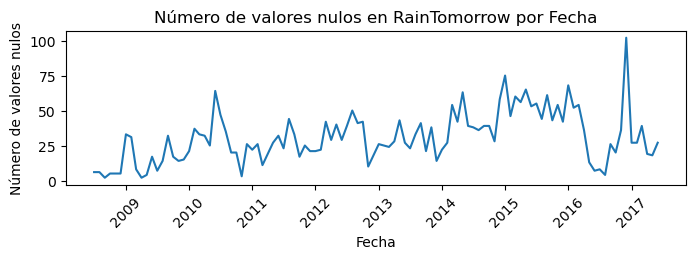

In [75]:
# nulls by Date for RainTomorrow column
df_graph = df.groupby('Date')['RainTomorrow'].apply(lambda x: x.isna().sum()).sort_values(ascending=False)
df_graph = df_graph[df_graph > 0]  # Filtrar solo fechas con valores nulos
# truncate mes/year
df_graph.index = pd.to_datetime(df_graph.index).to_period('M').to_timestamp()
df_graph = df_graph.groupby(df_graph.index).sum()

plt.figure(figsize=(8, 2))
plt.plot(df_graph.index, df_graph.values)
plt.title('Número de valores nulos en RainTomorrow por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de valores nulos')
plt.xticks(rotation=45)
plt.show()


In [214]:
# Crear un nuevo data frame con Raintomorrow and RainToday sin missings
df_clean = df.dropna(subset=['RainTomorrow','RainToday']).copy()

# Verificar que no hay missings en RainTomorrow
print("Missing en RainTomorrow: ",df_clean['RainTomorrow'].isna().sum())
print("Missing en RainToday: ",df_clean['RainToday'].isna().sum())

Missing en RainTomorrow:  0
Missing en RainToday:  0


<Axes: >

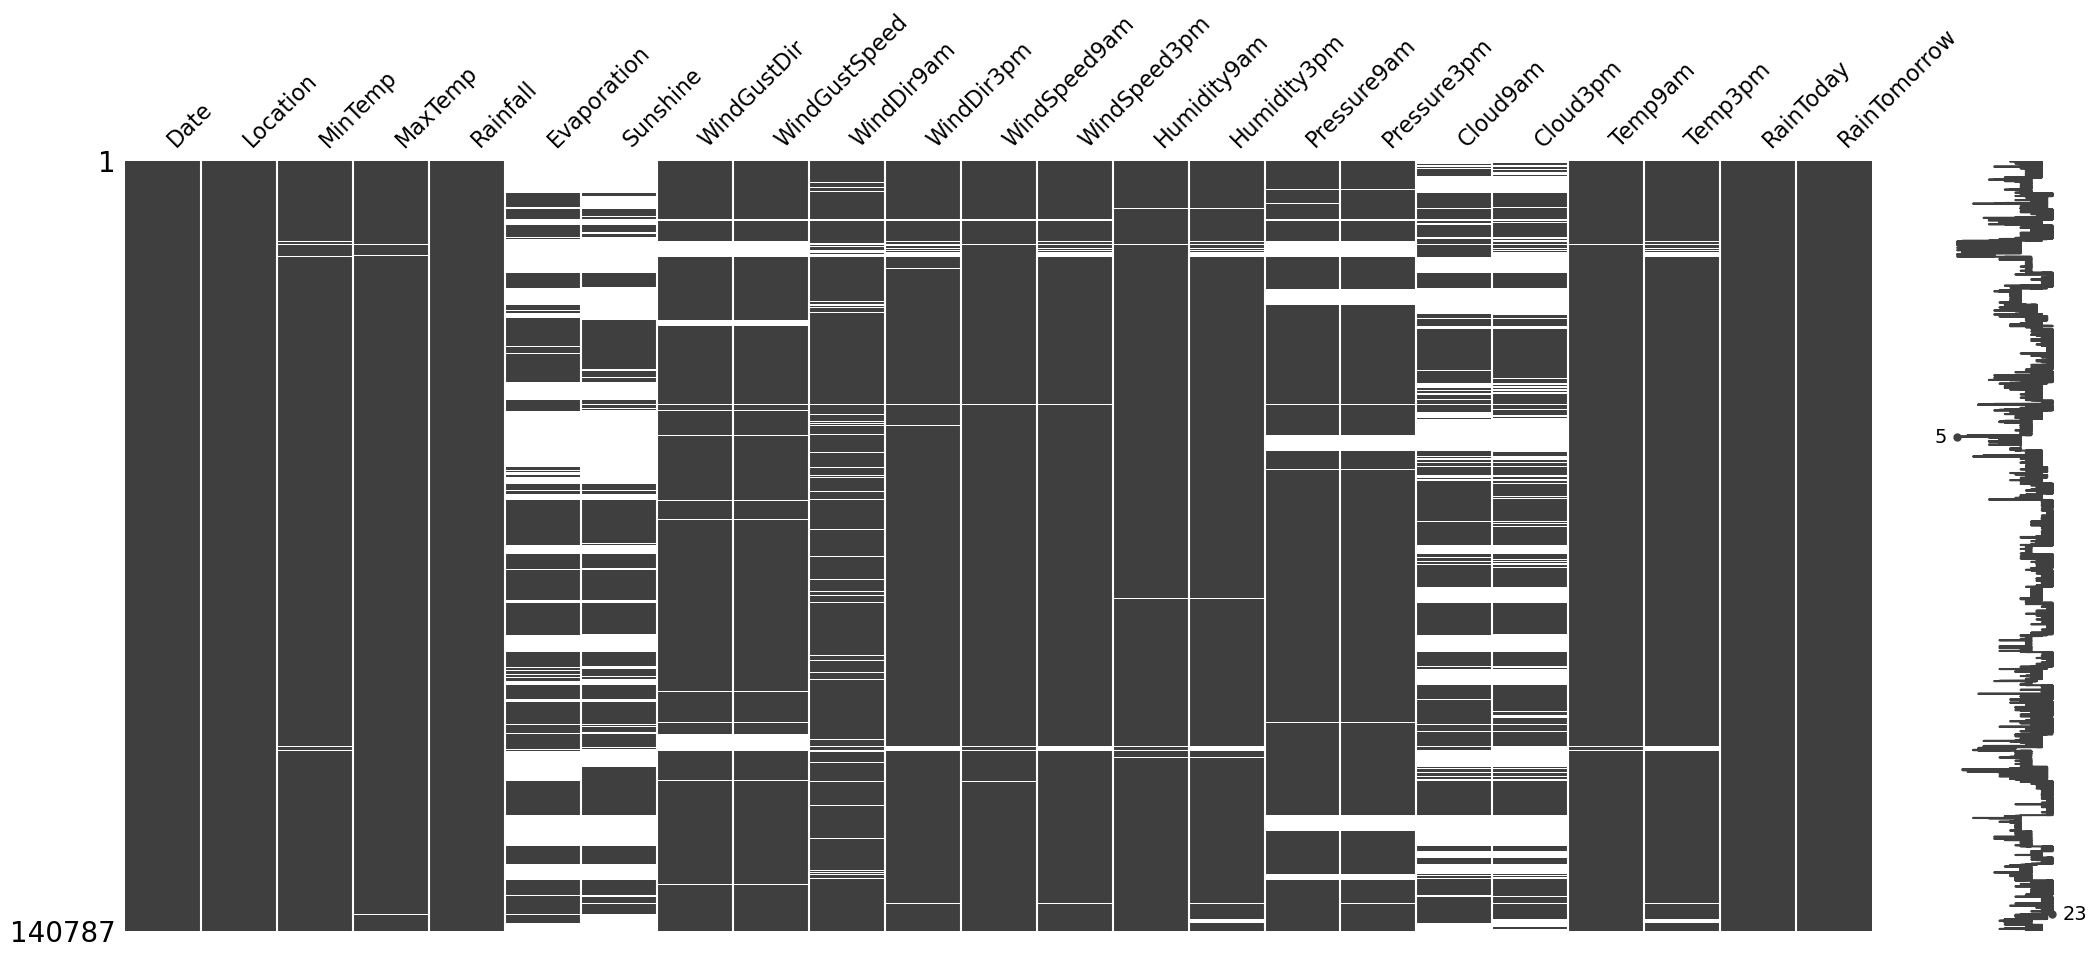

In [215]:
import missingno as msno
# Visualización de datos faltantes
msno.matrix(df_clean)

La matriz de missing values, nos muestra que hay features que coinciden en missings para similares rangos de tiempo y location. Se observa que hay features como: 
* WindGustSpeed y WinGustDir, RainToday y Rainfall, Pressure3pm y Pressure9am que tienen una correlación alta. Esto significa que si un feature está vacío, entonces el otro también estará vacío (idem. completo).

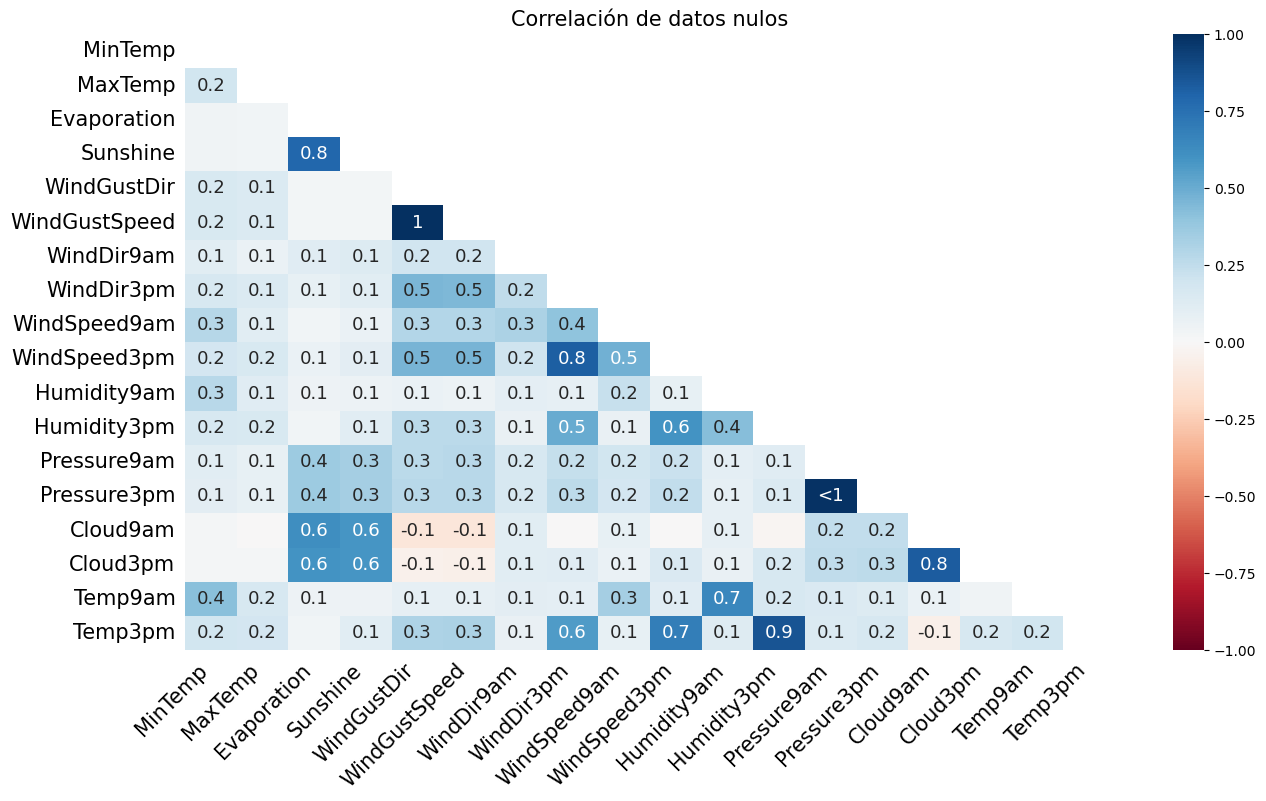

In [216]:
msno.heatmap(df_clean, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

Tenemos 5 Locations donde se concentran los missings para Pressure9am y Pressure3pm: 
* Launceston
* MountGinini
* Newcastle
* Penrith
* Sydney

In [ ]:
# Concentración de missings por Location
df_clean.groupby('Location').apply(lambda x: x.isna().sum())

C:\Users\peral\AppData\Local\Temp\ipykernel_17484\886374408.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean.groupby('Location').apply(lambda x: x.isna().sum())


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Location,,,,,,,,,,,,,,,,,,,,,,,
Adelaide,0,0,1,0,0,1372,1368,20,20,248,14,3,5,3,5,6,7,3020,3020,3,4,0,0
Albany,0,0,39,32,0,270,494,2996,2996,224,748,38,699,26,682,25,24,15,677,16,678,0,0
Albury,0,0,1,1,0,2991,2991,8,8,512,42,1,7,4,4,0,4,1716,1587,4,4,0,0
AliceSprings,0,0,1,1,0,205,505,49,49,229,4,2,2,2,4,1,3,330,354,0,2,0,0
BadgerysCreek,0,0,3,2,0,2877,2877,13,13,369,55,1,19,13,27,128,143,2877,2877,0,16,0,0
Ballarat,0,0,0,1,0,3017,3017,23,23,91,15,8,2,21,5,24,23,540,1036,12,4,0,0
Bendigo,0,0,1,1,0,1845,3030,36,35,243,42,3,3,5,1,14,9,960,764,2,1,0,0
Brisbane,0,0,2,4,0,19,48,12,12,67,27,0,2,2,9,0,2,1,2,2,9,0,0
Cairns,0,0,1,0,0,317,403,18,17,42,4,0,1,0,0,0,0,173,197,0,0,0,0


### Análisis de Outeliers y Descriptivo Univariado

In [218]:
# descriptive statistics function summary for numeric columns

def descriptive_statistics(dataframe):
    ds_df = dataframe.describe().T
    # numeric columns
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns
    # skewness and kurtosis
    for col in numeric_cols:
        ds_df.loc[col, 'skewness'] = dataframe[col].skew()
        ds_df.loc[col, 'excess_kurtosis'] = dataframe[col].kurtosis() # excess kurtosis
    
    # missing values
    ds_df['missing_count'] = dataframe.isnull().sum()
    ds_df['missing_percentage'] = (ds_df['missing_count'] / len(dataframe)) * 100

    # IQR and outliers
    ds_df['IQR'] = ds_df['75%'] - ds_df['25%']
    ds_df['outliers_count'] = 0
    for col in numeric_cols:
        Q1 = ds_df.loc[col, '25%']
        Q3 = ds_df.loc[col, '75%']
        IQR = ds_df.loc[col, 'IQR']
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]
        ds_df.loc[col, 'outliers_count'] = outliers.shape[0]
        # percentage of outliers
        ds_df.loc[col, 'outliers_percentage'] = (ds_df.loc[col, 'outliers_count'] / len(dataframe)) * 100

        # sigma rule
        lower_bound_sigma = ds_df.loc[col, 'mean'] - 3 * ds_df.loc[col, 'std']
        upper_bound_sigma = ds_df.loc[col, 'mean'] + 3 * ds_df.loc[col, 'std']
        sigma_outliers = dataframe[(dataframe[col] < lower_bound_sigma) | (dataframe[col] > upper_bound_sigma)]
        ds_df.loc[col, 'sigma_outliers_count'] = sigma_outliers.shape[0]
        # percentage of sigma outliers
        ds_df.loc[col, 'sigma_outliers_percentage'] = (ds_df.loc[col, 'sigma_outliers_count'] / len(dataframe)) * 100
    #print("Descriptive statistics calculated: \n")


    return ds_df

Se realiza un resumen descriptivo con estadísticos de variables numéricas.

Resumen Outliers:
* Usando el criterio del rango intercuartilico, tenemos ~17% de outliers en Rainfall, luego en WindGustSpeed un 2% aproximadamente. En el resto de variables es menor a 2%

Resumen Distribuciones:
* Usando el criterio Skewness y exceso de Kurtosis, tenemos que: 
    * Estas features tienen una distribucion similar a la normal:
        * MaxTemp, MinTemp, Pressure9am, Pressure3pm, Temp3pm, Temp9am
    * Estas features tienen una distribucion asimetrica con colas pesadas
        * Rainfall, Evaporation, WindSpeed9am, WindSpeed3pm, WindGustSpeed
    * Estas features tienen una distribucion asimetrica con colas menos pesadas
        * Humidity9am, Humidity3pm

In [219]:
resumen = descriptive_statistics(df_clean)
display(resumen)

,count,mean,std,min,25%,50%,75%,max,skewness,excess_kurtosis,missing_count,missing_percentage,IQR,outliers_count,outliers_percentage,sigma_outliers_count,sigma_outliers_percentage
MinTemp,140319.0,12.184824,6.403879,-8.5,7.6,12.0,16.8,33.9,0.026180,-0.490481,468,0.332417,9.2,61,0.043328,18.0,0.012785
MaxTemp,140480.0,23.235120,7.114500,-4.8,17.9,22.6,28.3,48.1,0.230173,-0.252785,307,0.218060,10.4,387,0.274883,292.0,0.207406
Rainfall,140787.0,2.349974,8.465173,0.0,0.0,0.0,0.8,371.0,9.888061,180.002097,0,0.000000,0.8,25228,17.919268,2409.0,1.711095
Evaporation,81093.0,5.472516,4.189132,0.0,2.6,4.8,7.4,145.0,3.750062,45.152676,59694,42.400222,4.8,1947,1.382940,853.0,0.605880
Sunshine,73982.0,7.630540,3.781729,0.0,4.9,8.5,10.7,14.5,-0.505034,-0.818324,66805,47.451114,5.8,0,0.000000,0.0,0.000000
WindGustSpeed,131682.0,39.970520,13.578201,6.0,31.0,39.0,48.0,135.0,0.871458,1.405272,9105,6.467216,17.0,2962,2.103887,1314.0,0.933325
WindSpeed9am,139732.0,13.990496,8.886210,0.0,7.0,13.0,19.0,130.0,0.774517,1.226553,1055,0.749359,12.0,1715,1.218152,1290.0,0.916278
WindSpeed3pm,138256.0,18.631141,8.798096,0.0,13.0,19.0,24.0,87.0,0.631407,0.780510,2531,1.797751,11.0,2420,1.718909,921.0,0.654180
Humidity9am,139270.0,68.826833,19.063650,0.0,57.0,70.0,83.0,100.0,-0.482213,-0.040644,1517,1.077514,26.0,1414,1.004354,471.0,0.334548
Humidity3pm,137286.0,51.449288,20.807310,0.0,37.0,52.0,66.0,100.0,0.034406,-0.513322,3501,2.486735,29.0,0,0.000000,0.0,0.000000


In [220]:
# graficas de distribuciones numéricas
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numeric_distributions(dataframe):
    subplot_rows = int(np.ceil(len(dataframe.select_dtypes(include=[np.number]).columns) / 3))
    subplot_cols = 3

    fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 5 * subplot_rows))
    axes = axes.flatten()

    for i, col in enumerate(dataframe.select_dtypes(include=[np.number]).columns):
        sns.histplot(dataframe[col].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f'Distribución de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

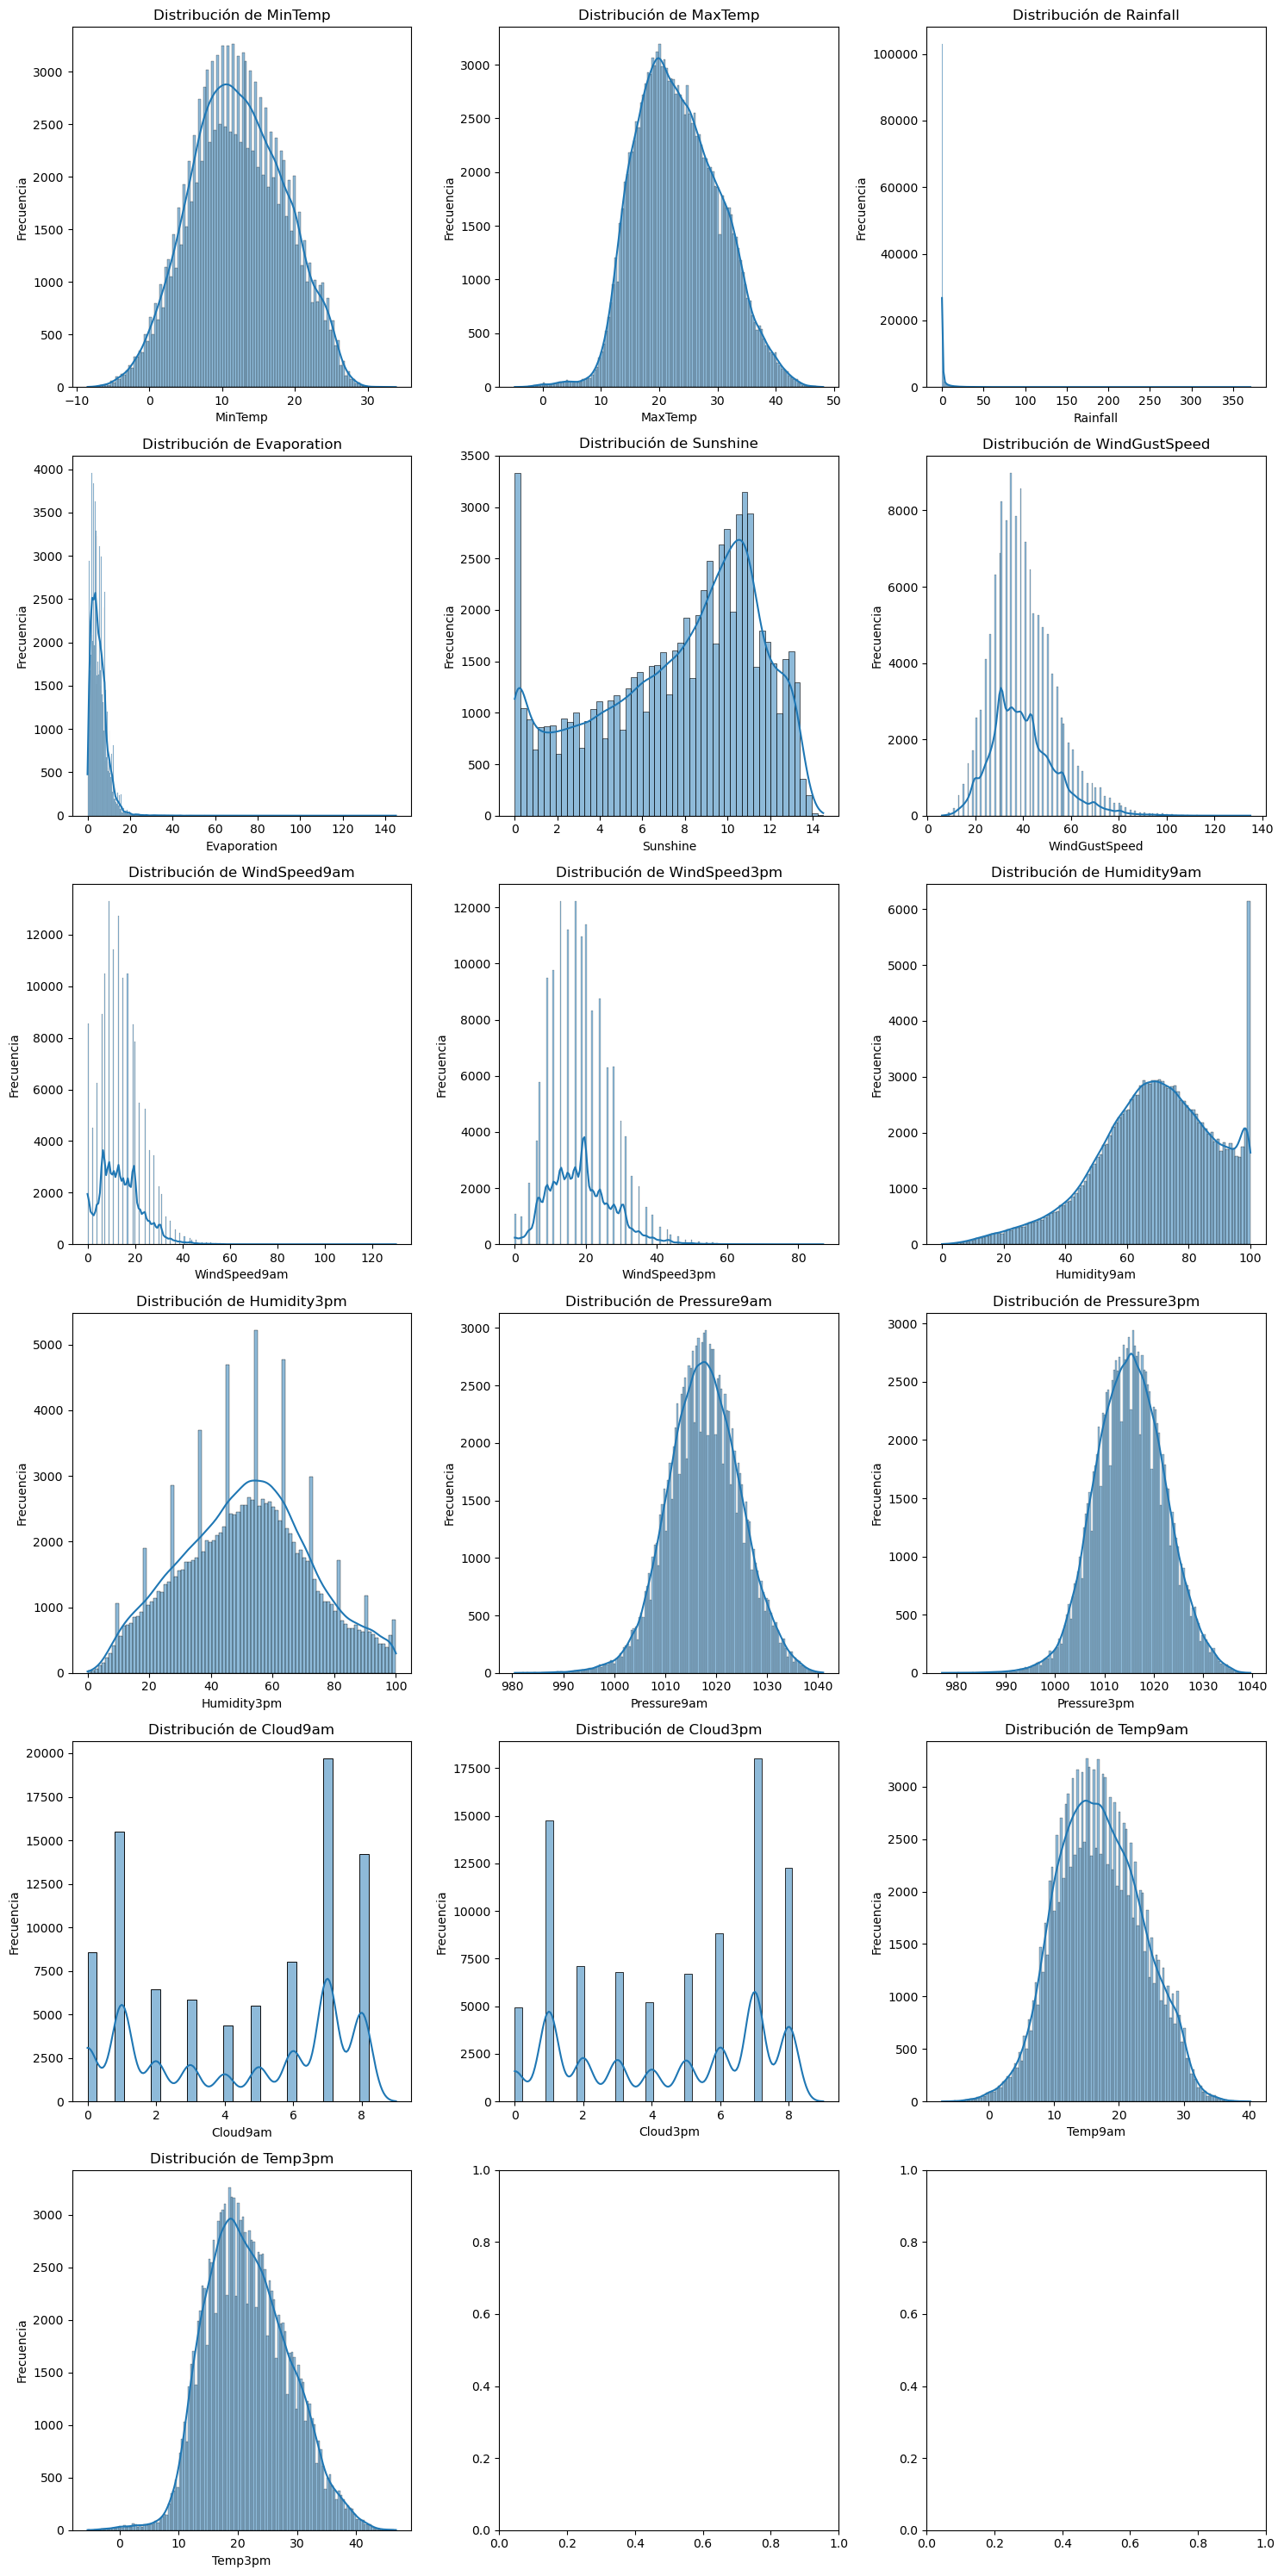

In [221]:
# Llamar a la función para graficar distribuciones numéricas
plot_numeric_distributions(df_clean)


In [222]:
# function to descriptive analysis categorical columns, unique values, missing, mode, entropy, entropy normalized
def descriptive_analysis_categorical(dataframe):
    categorical_cols = dataframe.select_dtypes(include=['object', 'category']).columns
    da_df = pd.DataFrame(index=categorical_cols, columns=['unique_values', 'missing_count','missing_percentage','mode', 'mode_frequency', 'mode_frequency_perc','entropy', 'entropy_normalized'])

    for col in categorical_cols:
        da_df.loc[col, 'unique_values'] = dataframe[col].nunique()
        da_df.loc[col, 'missing_count'] = dataframe[col].isnull().sum()
        da_df.loc[col, 'missing_percentage'] = (da_df.loc[col, 'missing_count'] / len(dataframe)) * 100
        da_df.loc[col, 'mode'] = dataframe[col].mode()[0]
        da_df.loc[col, 'mode_frequency'] = dataframe[col].value_counts().iloc[0]
        da_df.loc[col, 'mode_frequency_perc'] = (da_df.loc[col, 'mode_frequency'] / len(dataframe[col].dropna())) * 100

        # Entropy calculation
        value_counts = dataframe[col].value_counts(normalize=True)
        entropy = -np.sum(value_counts * np.log2(value_counts + 1e-9))  # Adding a small value to avoid log(0)
        da_df.loc[col, 'entropy'] = entropy

        # Normalized entropy
        max_entropy = np.log2(da_df.loc[col, 'unique_values'] + 1e-9)
        da_df.loc[col, 'entropy_normalized'] = entropy / max_entropy if max_entropy > 0 else 0

    display(da_df)

Se realiza un resumen descriptivo para variables categóricas:
* Revisando la entropia normalizada, se oberva que la mayoría tienen features con valores balanceados entre sí (entropia > 99%)
* No obstante, se observa que RainToday y RainTomorrow (target) tienen un entropía normalizada en 76%, esto nos da indicios de desbalance de datos. Además, si vemos que 77% de casos son No, entonces, observa un caso de ligero desbalance.

In [223]:
descriptive_analysis_categorical(df_clean)

,unique_values,missing_count,missing_percentage,mode,mode_frequency,mode_frequency_perc,entropy,entropy_normalized
Date,3436,0,0.0,2013-03-03,49,0.034804,11.61767,0.989031
Location,49,0,0.0,Canberra,3402,2.416416,5.599809,0.997346
WindGustDir,16,9163,6.508413,W,9696,7.366438,3.989804,0.997451
WindDir9am,16,9660,6.861429,N,11266,8.591671,3.989229,0.997307
WindDir3pm,16,3670,2.606775,SE,10578,7.71458,3.990913,0.997728
RainToday,2,0,0.0,No,109332,77.657738,0.766368,0.766368
RainTomorrow,2,0,0.0,No,109586,77.838153,0.763112,0.763112


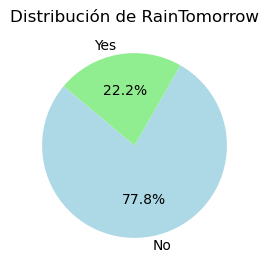

In [225]:
# pie chart for raintomorrow
labels = df_clean['RainTomorrow'].value_counts().index
sizes = df_clean['RainTomorrow'].value_counts().values
colors = ['lightblue', 'lightgreen']
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de RainTomorrow')
plt.show()

### Análisis descriptivo Bivariado

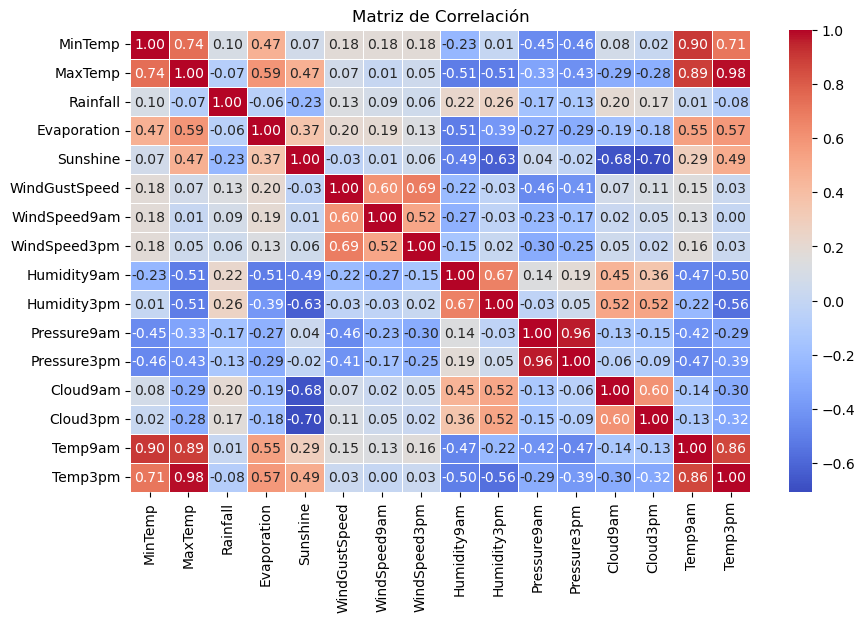

In [274]:
# Seleccionar solo columnas numéricas
numeric_df = df_clean.select_dtypes(include='number')

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Crear un gráfico de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

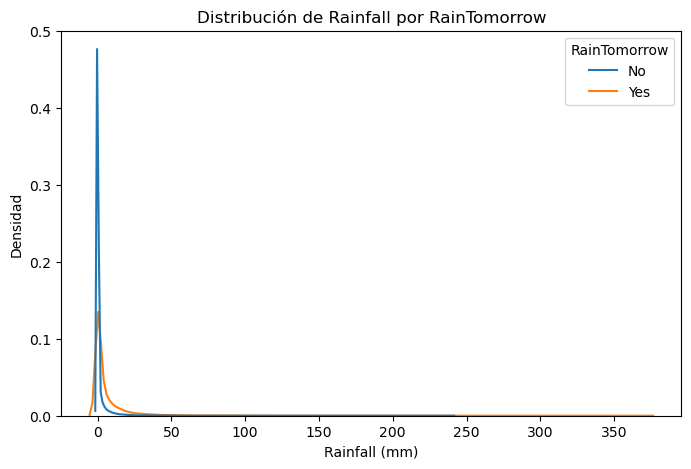

In [262]:
# kde rainfall by raintomorrow
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_clean, x='Rainfall', hue='RainTomorrow', common_norm=False)
plt.title('Distribución de Rainfall por RainTomorrow')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Densidad')
plt.show()


## 3. Preprocesamiento de los datos


### Tratamiento de Missings and Outliers

Missings
* Dropear features con missing extremos> Sunshine 48%, Evaporation 43%, Cloud3pm 40% y Cloud9am
* Aplicar imputación hacia adelante dado que son series de tiempo, usaremos un límit de 7 días

Outliers
* Hacer Capping de datos en features con outliers > 1% mediante capping:
    * Capping upper por distribucion asimétrica positiva: WindSpeed9am, WindSpeed3pm, WindGustSpeed
    * En el caso de Rainfall usaremos la técnica de discretización para controlar los outliers, además, dado que los extremos tienen más chance que se mantenga la lluvia al día siguiente

In [277]:
# missing imputation forward fill by Date and Location without modifying original dataframe
def preprocess_missing_data(dataframe):
    
    # drop columns with too many missings without modifying original dataframe
    dataframe_filled = dataframe.drop(columns=['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']).copy()

    # missing imputation forward fill by Date and Location
    dataframe_filled.sort_values(by=['Location', 'Date'], inplace=True)
    dataframe_filled = dataframe_filled.ffill(limit=7)

    #drop na rows that still have missings                ## revisar para optimizar mejor
    dataframe_filled = dataframe_filled.dropna()
    return dataframe_filled

In [278]:
df_pre_processed_missing = preprocess_missing_data(df_clean)

In [281]:
# validar missings
print("Missing values after preprocessing:\n", df_pre_processed_missing.isnull().sum())

Missing values after preprocessing:
 Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


In [282]:
# discretizar rainfall
def discretize_rainfall(value):
    if pd.isna(value):
        return np.nan
    elif value == 0:
        return 'No Rain'
    elif 0 < value <= 10:
        return 'Light Rain'
    elif 10 < value <= 50:
        return 'Moderate Rain'
    else:
        return 'Heavy Rain'
    
def preprocess_outliers_data(dataframe):
    dataframe_processed = dataframe.copy()
    # Discretizar Rainfall
    dataframe_processed['Rainfall_Discretized'] = dataframe_processed['Rainfall'].apply(discretize_rainfall)
    # drop original Rainfall column
    dataframe_processed = dataframe_processed.drop(columns=['Rainfall'])
    # Capping WindSpeed9am, WindSpeed3pm, WindGustSpeed at 99th percentile to handle outliers clip
    for col in ['WindSpeed9am', 'WindSpeed3pm', 'WindGustSpeed']:
        upper_limit = dataframe_processed[col].quantile(0.99)
        dataframe_processed[col] = dataframe_processed[col].clip(upper=upper_limit)
    
    return dataframe_processed

In [283]:
df_pre_processed = preprocess_outliers_data(df_pre_processed_missing)

In [ ]:
# guardar preprocessed dataset
df_pre_processed.to_csv('dataset/weatherAUS_preprocessed.csv', index=False)

In [46]:
df_pre_processed = pd.read_csv('dataset/weatherAUS_preprocessed.csv')
df_pre_processed['Date'] = pd.to_datetime(df_pre_processed['Date'])

In [47]:
df_pre_processed = df_pre_processed.sort_values(["Date", "Location"]).reset_index(drop=True)

### Split y escalamiento

In [48]:
# Dividir en conjunto de entrenamiento (2016-2017) y prueba (otros años)

years = [2016, 2017]
df_train = df_pre_processed[~df_pre_processed['Date'].dt.year.isin(years)].copy()
df_test = df_pre_processed[df_pre_processed['Date'].dt.year.isin(years)].copy()
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
X_train = df_train.drop(columns=['RainTomorrow', 'Date'])
y_train = df_train['RainTomorrow'].map({'No': 0, 'Yes': 1})  # codificar como 0 y 1
X_test = df_test.drop(columns=['RainTomorrow', 'Date'])
y_test = df_test['RainTomorrow'].map({'No': 0, 'Yes': 1})  # codificar como 0 y 1

print("Tamaño de X_train:", X_train.shape, " - Tamaño de X_test:", X_test.shape)
print("Distribución de clases en y_train:")
print(y_train.value_counts())
print("Distribución de clases en y_test:")
print(y_test.value_counts())

Tamaño de X_train: (100286, 17)  - Tamaño de X_test: (21854, 17)
Distribución de clases en y_train:
RainTomorrow
0    78457
1    21829
Name: count, dtype: int64
Distribución de clases en y_test:
RainTomorrow
0    16899
1     4955
Name: count, dtype: int64



Realizaremos varias tareas de transformación:
- Transformación de variables categóricas a variables numéricas mediante *one-hot encoding*.
- Escalado de las características numéricas para que queden en rangos comparables.

In [49]:
from models import preprocessing

# 4. Codificar variables categóricas y escalar características numéricas
X_train_proc, X_test_proc = preprocessing.transformar_features(X_train, X_test)

# Verificamos el resultado de la transformación
print("Características procesadas - columnas:", X_train_proc.shape[1])
print("Primeras columnas:", X_train_proc.columns[:5].tolist(), "...")
# Mostrar ejemplo de una fila procesada
display(X_train_proc.head(1))

Características procesadas - columnas: 107
Primeras columnas: ['MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'] ...


,MinTemp,MaxTemp,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,Rainfall_Discretized_Light Rain,Rainfall_Discretized_Moderate Rain,Rainfall_Discretized_No Rain
0,0.384798,0.476923,0.32,0.153846,0.465116,0.68,0.29,0.647934,0.594059,0.404157,0.486301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 4. Entrenamiento y evaluación de modelos

Entrenaremos cinco modelos de clasificación binaria distintos utilizando el conjunto de entrenamiento:
- **Regresión Logística**
- **Naive Bayes (Gaussiano)**
- **K-Nearest Neighbors (KNN)**
- **Random Forest**
- **XGBoost**


Usaremos implementaciones de scikit-learn, encapsuladas en funciones modulares. Cada función entrena su modelo y realiza predicciones sobre el conjunto de prueba. Luego evaluaremos el desempeño de cada modelo mediante métricas como **Accuracy**, **Precision**, **Recall**, **F1-score**, **roc_auc score** y **Brier score**, además de visualizar la matriz de confusión.

In [50]:
# Importar módulos de modelos y métricas
from models import logistic_regression, naive_bayes, knn, random_forest, xgboost
from models import metrics_utils

# Entrenar y predecir con cada modelo
models = {}
predictions = {}  # para guardar predicciones y probabilidades
metrics_results = {}

# 3.1 Regresión Logística
print("Entrenando modelo de Regresión Logística...")
model_log, y_pred_log, y_prob_log = logistic_regression.train_and_predict(X_train_proc, y_train, X_test_proc)
models['Logistic'] = model_log
predictions['Logistic'] = (y_pred_log, y_prob_log)
metrics_results['Logistic'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_log, y_prob_log)
print("Métricas Regresión Logística:", metrics_results['Logistic'])

Entrenando modelo de Regresión Logística...
Métricas Regresión Logística: {'accuracy': 0.8453829962478265, 'precision': 0.7145969498910676, 'recall': 0.5295660948536831, 'f1': 0.6083227077779065, 'brier_score': 0.11150366799600664, 'roc_auc': 0.8650571278556537}


In [51]:
# 3.2 Naive Bayes Gaussiano
print("\nEntrenando modelo de Naive Bayes...")
model_nb, y_pred_nb, y_prob_nb = naive_bayes.train_and_predict(X_train_proc, y_train, X_test_proc)
models['NaiveBayes'] = model_nb
predictions['NaiveBayes'] = (y_pred_nb, y_prob_nb)
metrics_results['NaiveBayes'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_nb, y_prob_nb)
print("Métricas Naive Bayes:", metrics_results['NaiveBayes'])


Entrenando modelo de Naive Bayes...
Métricas Naive Bayes: {'accuracy': 0.4996796925048046, 'precision': 0.29194794348945646, 'recall': 0.8466195761856711, 'f1': 0.4341751190229766, 'brier_score': 0.4764176736442459, 'roc_auc': 0.7281160183052288}


In [52]:
# 3.3 K-Nearest Neighbors
print("\nEntrenando modelo KNN...")
model_knn, y_pred_knn, y_prob_knn = knn.train_and_predict(X_train_proc, y_train, X_test_proc)
models['KNN'] = model_knn
predictions['KNN'] = (y_pred_knn, y_prob_knn)
metrics_results['KNN'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_knn, y_prob_knn)
print("Métricas KNN:", metrics_results['KNN'])


Entrenando modelo KNN...
Métricas KNN: {'accuracy': 0.799167200512492, 'precision': 0.5942704863424384, 'recall': 0.36004036326942485, 'f1': 0.4484102048510745, 'brier_score': 0.1521131143040176, 'roc_auc': 0.7452156036675186}


In [53]:
# 3.4 Random Forest
print("\nEntrenando modelo Random Forest...")
model_rf, y_pred_rf, y_prob_rf = random_forest.train_and_predict(X_train_proc, y_train, X_test_proc)
models['RandomForest'] = model_rf
predictions['RandomForest'] = (y_pred_rf, y_prob_rf)
metrics_results['RandomForest'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_rf, y_prob_rf)
print("Métricas Random Forest:", metrics_results['RandomForest'])


Entrenando modelo Random Forest...
Métricas Random Forest: {'accuracy': 0.8488606204813764, 'precision': 0.7461263408820024, 'recall': 0.5053481331987891, 'f1': 0.602574900733967, 'brier_score': 0.10904207925322595, 'roc_auc': 0.8752848779437447}


In [54]:
# 3.5 XGBoost
print("\nEntrenando modelo XGBoost...")
model_xgb, y_pred_xgb, y_prob_xgb = xgboost.train_and_predict(X_train_proc, y_train, X_test_proc)
models['XGBoost'] = model_xgb
predictions['XGBoost'] = (y_pred_xgb, y_prob_xgb)
metrics_results['XGBoost'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_xgb, y_prob_xgb)
print("Métricas XGBoost:", metrics_results['XGBoost'])


Entrenando modelo XGBoost...
Métricas XGBoost: {'accuracy': 0.8528873432781184, 'precision': 0.7419354838709677, 'recall': 0.5384460141271443, 'f1': 0.6240205823880248, 'brier_score': 0.10622007996738378, 'roc_auc': 0.8807465723973302}


Resultados Preliminares de los 5 modelos, dado que tenemos un cierto grado de desbalanceo de datos, opataremos en priorizar auc-score, recall y f1:
* ROC-AUC Score> XGBoost, RandomForest y Logistic son los modelos con mejor resultado
* Recall> Si bien los modelos de XGBoost, RandomForest y Logistic tienen bajo recal, se podría optimizar aumentar más mediante hyperparameter tunning o eligiendo threshold más bajos
* F1 Score> XGBoost, RandomForest y Logistic son los modelos con mejor resultado

In [ ]:
# comparativo 5 modelos
metrics_comparison = pd.DataFrame(metrics_results).T
display(metrics_comparison)


,accuracy,precision,recall,f1,brier_score,roc_auc
Logistic,0.845383,0.714597,0.529566,0.608323,0.111504,0.865057
NaiveBayes,0.499680,0.291948,0.846620,0.434175,0.476418,0.728116
KNN,0.799167,0.594270,0.360040,0.448410,0.152113,0.745216
RandomForest,0.848861,0.746126,0.505348,0.602575,0.109042,0.875285
XGBoost,0.852887,0.741935,0.538446,0.624021,0.106220,0.880747


In [ ]:
# Display ROC curves for all models
plt.figure(figsize=(10, 8))
for model_name, (y_pred, y_prob) in predictions.items():
    fpr, tpr, _ = metrics_utils.calcular_roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {metrics_results[model_name]["AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC de los Modelos')
plt.legend()
plt.show()

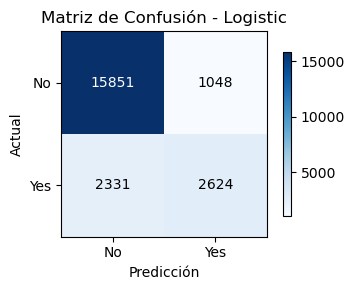

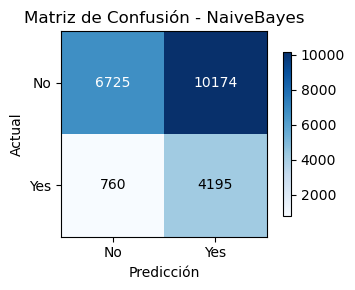

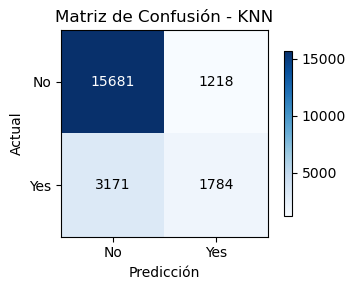

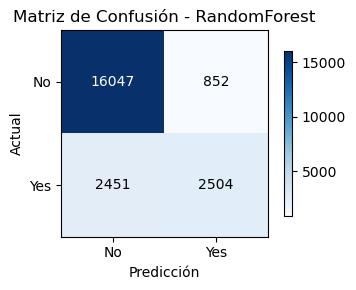

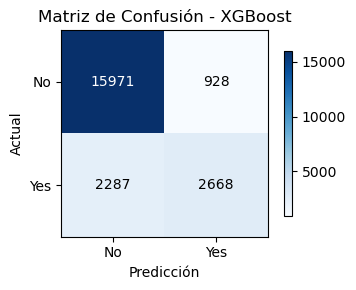

In [56]:
# Visualización de matrices de confusión para cada modelo
import matplotlib.pyplot as plt

for model_name, (y_pred, y_prob) in predictions.items():
    metrics_utils.plot_confusion_matrix(y_test, y_pred, title=f"Matriz de Confusión - {model_name}")
    plt.show()

## 5. Hyperparameter Tunning

Dado que obtuvimos mejores resultados con XGBoost, RF y Logistic. Evaluaremos nuevamente el modelo, luego del hyperparameter tunning para validar si hubo una mejora

### XGoost

Tenemos 5 Locations donde se concentran los missings para Pressure9am y Pressure3pm: 
* Launceston
* MountGinini
* Newcastle
* Penrith
* Sydney

Dado que tenemos un modelo con serie temporal, usaremos TimeSeriesSplit en lugar de un Cross Validation normal. Asimismo, usaremos Optuna para hacerla la búsqueda de hiperparametros dandole como objetivo intervalos de hiperparametros de XGBoost, la métrica a optimizar sera roc-auc score dado que es un dataset desbalanceado.

In [57]:
import optuna
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import numpy as np

# ---------------------------------------------------------
# DEFINIR FUNCIÓN OBJETIVO PARA OPTUNA
# ---------------------------------------------------------
def objective(trial):

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",       # Rápido y estable
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),    # L2
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),     # L1
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "n_estimators": trial.suggest_int("n_estimators", 300, 2000),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 10.0),
        "random_state": 42
    }

    # VALIDACIÓN TEMPORAL
    tscv = TimeSeriesSplit(n_splits=5)

    aucs = []
    

    for train_idx, val_idx in tscv.split(X_train_proc):
        X_train1, X_valid = X_train_proc.iloc[train_idx], X_train_proc.iloc[val_idx]
        y_train1, y_valid = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(**params)

        model.fit(
            X_train1, y_train1,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )

        y_pred = model.predict_proba(X_valid)[:, 1]
        aucs.append(roc_auc_score(y_valid, y_pred))

    return np.mean(aucs)



In [58]:
# ---------------------------------------------------------
# EJECUTAR OPTUNA
# ---------------------------------------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best score:", study.best_value)
print("Best hyperparameters:", study.best_params)


[I 2025-12-09 18:04:42,106] A new study created in memory with name: no-name-4f894d8d-daf0-440c-9c1e-c7a0b72eb27b


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-09 18:05:19,702] Trial 0 finished with value: 0.8842567233709792 and parameters: {'learning_rate': 0.16563410910013227, 'max_depth': 10, 'min_child_weight': 18, 'lambda': 1.405545810697159e-07, 'alpha': 0.0005436663190068751, 'subsample': 0.5376213008172984, 'colsample_bytree': 0.7559448647601075, 'gamma': 9.534289101672645, 'n_estimators': 1972, 'scale_pos_weight': 1.7483424150822304}. Best is trial 0 with value: 0.8842567233709792.
[I 2025-12-09 18:05:36,057] Trial 1 finished with value: 0.8757354918194558 and parameters: {'learning_rate': 0.032851081115327106, 'max_depth': 5, 'min_child_weight': 19, 'lambda': 0.0014492966739078465, 'alpha': 0.005943770935765491, 'subsample': 0.8464654538751564, 'colsample_bytree': 0.9120149594101556, 'gamma': 9.98647835386793, 'n_estimators': 760, 'scale_pos_weight': 0.611164208258798}. Best is trial 0 with value: 0.8842567233709792.
[I 2025-12-09 18:06:06,384] Trial 2 finished with value: 0.8855767568012579 and parameters: {'learning_rat

In [59]:
best_params = study.best_params

best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "random_state": 42
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_proc, y_train)

print("\nModelo final entrenado con los mejores hiperparámetros.")



Modelo final entrenado con los mejores hiperparámetros.


In [60]:
# XGBoost Optimized evaluation
models['XGBoost_Optimized'] = final_model
predictions['XGBoost_Optimized'] = (final_model.predict(X_test_proc), final_model.predict_proba(X_test_proc)[:, 1])
metrics_results['XGBoost_Optimized'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['XGBoost_Optimized'][0], predictions['XGBoost_Optimized'][1])
print("Métricas XGBoost Optimized:", metrics_results['XGBoost_Optimized'])

Métricas XGBoost Optimized: {'accuracy': 0.7371648210853848, 'precision': 0.45902150202555314, 'recall': 0.8918264379414732, 'f1': 0.6060896996296804, 'brier_score': 0.17922883910528856, 'roc_auc': 0.8913576588969344}


In [61]:
# Export XGBoost Optimized model
import joblib
joblib.dump(final_model, 'trained_models/xgboost_optimized_model.pkl')
print("Modelo XGBoost Optimized guardado en 'trained_models/xgboost_optimized_model.pkl'.")

Modelo XGBoost Optimized guardado en 'trained_models/xgboost_optimized_model.pkl'.


### Random Forest

Se replica TimeSeriesSplit en lugar de un Cross Validation normal. Ajustaremos la funcion objetivo con los hiperparametros del Random Forest, probamos con el hiperparametro "class_weigth" para balanced.

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import numpy as np

# ---------------------------------------------------------
# FUNCIÓN OBJETIVO PARA OPTUNA (Random Forest)
# ---------------------------------------------------------
def objective_rf(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 40),
        "n_estimators": trial.suggest_int("n_estimators", 200, 900),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 30),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.05),
        "random_state": 42,
        "n_jobs": -1,
    }

    # VALIDACIÓN TEMPORAL
    tscv = TimeSeriesSplit(n_splits=4)  # usar 4 splits para RF

    aucs = []

    for train_idx, val_idx in tscv.split(X_train_proc):
        X_train1, X_valid = X_train_proc.iloc[train_idx], X_train_proc.iloc[val_idx]
        y_train1, y_valid = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestClassifier(**params)

        model.fit(X_train1, y_train1)

        y_pred = model.predict_proba(X_valid)[:, 1]
        aucs.append(roc_auc_score(y_valid, y_pred))

    return np.mean(aucs)


In [69]:
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=30, show_progress_bar=True)

print("Best AUC RF:", study_rf.best_value)
print("Best Params RF:", study_rf.best_params)


[I 2025-12-09 19:49:18,706] A new study created in memory with name: no-name-fd80c41d-9179-4407-9d98-78e5cdf44625


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-09 19:49:31,127] Trial 0 finished with value: 0.7021923557339939 and parameters: {'n_estimators': 525, 'max_depth': 24, 'min_samples_split': 45, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': False, 'class_weight': None, 'ccp_alpha': 0.0463482746348575}. Best is trial 0 with value: 0.7021923557339939.
[I 2025-12-09 19:49:43,500] Trial 1 finished with value: 0.7955239569423641 and parameters: {'n_estimators': 375, 'max_depth': 37, 'min_samples_split': 4, 'min_samples_leaf': 29, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced', 'ccp_alpha': 0.039272307487499325}. Best is trial 1 with value: 0.7955239569423641.
[I 2025-12-09 19:51:14,681] Trial 2 finished with value: 0.7021923557339939 and parameters: {'n_estimators': 294, 'max_depth': 38, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': False, 'class_weight': None, 'ccp_alpha': 0.02025251797654731}. Best is trial 1 with value: 0.7955239569423641.
[I 2025-12-

In [70]:
best_params_rf = study_rf.best_params

final_rf = RandomForestClassifier(
    **best_params_rf,
    random_state=42
)

final_rf.fit(X_train_proc, y_train)
print("\nModelo Random Forest final entrenado con los mejores hiperparámetros.")


Modelo Random Forest final entrenado con los mejores hiperparámetros.


In [71]:
# RandomForest Optimized evaluation
models['RandomForest_Optimized'] = final_rf
predictions['RandomForest_Optimized'] = (final_rf.predict(X_test_proc), final_rf.predict_proba(X_test_proc)[:, 1])
metrics_results['RandomForest_Optimized'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['RandomForest_Optimized'][0], predictions['RandomForest_Optimized'][1])
print("Métricas RandomForest Optimized:", metrics_results['RandomForest_Optimized'])

Métricas RandomForest Optimized: {'accuracy': 0.779033586528782, 'precision': 0.5085066162570888, 'recall': 0.7600403632694248, 'f1': 0.6093358142545101, 'brier_score': 0.15581620370367202, 'roc_auc': 0.8556887244087847}


In [72]:
# Export Random Forest Optimized model
import joblib
joblib.dump(final_model, 'trained_models/random_forest_optimized_model.pkl')
print("Modelo Random Forest Optimized guardado en 'trained_models/random_forest_optimized_model.pkl'.")

Modelo Random Forest Optimized guardado en 'trained_models/random_forest_optimized_model.pkl'.


### Logistic

In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import numpy as np

def objective_logit(trial):

    # Penalties disponibles
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs", "saga"])

     # invalid combinations → prune immediately
    invalid_combo = (
        (penalty == "l1" and solver not in ["liblinear", "saga"]) or
        (penalty == "elasticnet" and solver != "saga") or
        (penalty == "l2" and solver not in ["lbfgs", "liblinear", "saga"])
    )

    if invalid_combo:
        raise optuna.TrialPruned()
    # Hiperparámetros base
    params = {
        "penalty": penalty,
        "solver": solver,
        "C": trial.suggest_float("C", 1e-4, 50.0, log=True),
        "max_iter": trial.suggest_int("max_iter", 200, 2000),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "random_state": 42
    }

    # Solo para elasticnet
    if penalty == "elasticnet":
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)   # proporción L1 vs L2

    # Solo para liblinear
    if solver == "liblinear":
        params["intercept_scaling"] = trial.suggest_float("intercept_scaling", 0.5, 5.0)

    # VALIDACIÓN TEMPORAL
    tscv = TimeSeriesSplit(n_splits=4)

    aucs = []

    for train_idx, val_idx in tscv.split(X_train_proc):
        X_train1, X_valid = X_train_proc.iloc[train_idx], X_train_proc.iloc[val_idx]
        y_train1, y_valid = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = LogisticRegression(**params)
        model.fit(X_train1, y_train1)

        y_pred = model.predict_proba(X_valid)[:, 1]
        aucs.append(roc_auc_score(y_valid, y_pred))

    return np.mean(aucs)


In [80]:
study_logit = optuna.create_study(direction="maximize")
study_logit.optimize(objective_logit, n_trials=30, show_progress_bar=True)

print("Best AUC Logit:", study_logit.best_value)
print("Best Params Logit:", study_logit.best_params)

[I 2025-12-09 20:29:58,942] A new study created in memory with name: no-name-33a74e19-db8a-4d71-9f2b-a281c7eceb77


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-09 20:30:02,292] Trial 0 finished with value: 0.8568930838688094 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'C': 0.009467323326371964, 'max_iter': 1260, 'tol': 0.0001754483373981263, 'fit_intercept': True, 'class_weight': None, 'l1_ratio': 0.8717048210822972}. Best is trial 0 with value: 0.8568930838688094.
[I 2025-12-09 20:30:10,212] Trial 1 finished with value: 0.873687490561478 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.14019293729739116, 'max_iter': 756, 'tol': 4.764056195550611e-06, 'fit_intercept': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.873687490561478.
[I 2025-12-09 20:30:10,932] Trial 2 finished with value: 0.8347278017980783 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.0031622058509161856, 'max_iter': 1401, 'tol': 4.953069464389325e-06, 'fit_intercept': False, 'class_weight': None, 'intercept_scaling': 1.3270624630274865}. Best is trial 1 with value: 0.873687490561478.
[I 2025-12-09 20:30:

In [82]:
best_params_logit = study_logit.best_params
final_logit = LogisticRegression(
    **best_params_logit,
    random_state=42,
    n_jobs=-1
)
final_logit.fit(X_train_proc, y_train)
print("\nModelo Logistic Regression final entrenado con los mejores hiperparámetros.")


Modelo Logistic Regression final entrenado con los mejores hiperparámetros.


In [83]:
# Logistic Regression Optimized evaluation
models['LogisticRegression_Optimized'] = final_logit
predictions['LogisticRegression_Optimized'] = (final_logit.predict(X_test_proc), final_logit.predict_proba(X_test_proc)[:, 1])
metrics_results['LogisticRegression_Optimized'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['LogisticRegression_Optimized'][0], predictions['LogisticRegression_Optimized'][1])
print("Métricas Logistic Regression Optimized:", metrics_results['LogisticRegression_Optimized'])

Métricas Logistic Regression Optimized: {'accuracy': 0.7866752081998719, 'precision': 0.5196512407780013, 'recall': 0.7818365287588295, 'f1': 0.6243352135374698, 'brier_score': 0.14974482405489137, 'roc_auc': 0.8669696957211627}


Resultados con modelos optimizados 

In [ ]:
# comparativo 5 modelos
metrics_comparison_final = pd.DataFrame(metrics_results).T
display(metrics_comparison_final)


,accuracy,precision,recall,f1,brier_score,roc_auc
Logistic,0.845383,0.714597,0.529566,0.608323,0.111504,0.865057
NaiveBayes,0.499680,0.291948,0.846620,0.434175,0.476418,0.728116
KNN,0.799167,0.594270,0.360040,0.448410,0.152113,0.745216
RandomForest,0.848861,0.746126,0.505348,0.602575,0.109042,0.875285
XGBoost,0.852887,0.741935,0.538446,0.624021,0.106220,0.880747
XGBoost_Optimized,0.737165,0.459022,0.891826,0.606090,0.179229,0.891358
RandomForest_Optimized,0.779034,0.508507,0.760040,0.609336,0.155816,0.855689
LogisticRegression_Optimized,0.786675,0.519651,0.781837,0.624335,0.149745,0.866970


## 5. Calibración de probabilidades

Algunos modelos (especialmente Random Forest, etc.) pueden no estar bien **calibrados** en términos de probabilidad – es decir, la probabilidad estimada de "lluvia" podría no reflejar la frecuencia real observada. Por ejemplo, puede predecir "0.9" de probabilidad de lluvia en muchos casos donde en realidad sólo llueve en un 70% de ellos (sobreestimación). Para mejorar esto, aplicamos **calibración** de probabilidades:
- **Platt Scaling (Sigmoide)**: ajusta una regresión logística sobre las salidas del modelo original.
- **Isotonic Regression (Regresión Isotónica)**: ajusta un modelo no paramétrico monotónico sobre las probabilidades, más flexible pero con riesgo de sobreajuste si hay pocos datos.

A continuación calibramos el modelo Random Forest (uno de los más precisos) usando ambos métodos y comparamos.

In [93]:
from models import calibratecopy1


# Calibrar Logistic Regression Optimizated con Regresión Isotónica
calibrated_logit_iso = calibratecopy1.calibrate_isotonic_cv(X_train_proc, y_train, final_logit)

# Calibrar Random Forest Optimizated con Regresión Isotónica
calibrated_rf_iso = calibratecopy1.calibrate_isotonic_cv(X_train_proc, y_train, final_rf)

# Calibrar XGboost Regression Optimizated con Regresión Isotónica
calibrated_xgb_iso = calibratecopy1.calibrate_isotonic_cv(X_train_proc, y_train, final_model)


# Obtener nuevas probabilidades calibradas en el conjunto de prueba
y_prob_rf_iso   = calibrated_rf_iso.predict_proba(X_test_proc)[:, 1]
y_prob_logit_iso = calibrated_logit_iso.predict_proba(X_test_proc)[:, 1]
y_prob_xgb_iso  = calibrated_xgb_iso.predict_proba(X_test_proc)[:, 1]


In [116]:
# exportar calibrated models
import joblib
joblib.dump(calibrated_logit_iso, 'trained_models/logistic_regression_calibrated_model.pkl')
joblib.dump(calibrated_rf_iso, 'trained_models/random_forest_calibrated_model.pkl')
joblib.dump(calibrated_xgb_iso, 'trained_models/xgboost_calibrated_model.pkl')
print("Modelos calibrados guardados en 'trained_models/'.")

Modelos calibrados guardados en 'trained_models/'.


In [95]:
# Agregar modelos calibrados al diccionario de modelos
models['LogisticRegression_Optimized_Calibrated_Isotonic'] = calibrated_logit_iso
models['RandomForest_Optimized_Calibrated_Isotonic'] = calibrated_rf_iso
models['XGBoost_Optimized_Calibrated_Isotonic'] = calibrated_xgb_iso

In [98]:
# Agregar probabilidades calibradas a las predicciones
predictions['RandomForest_Optimized_Calibrated_Isotonic'] = (calibrated_rf_iso.predict(X_test_proc), y_prob_rf_iso)
predictions['LogisticRegression_Optimized_Calibrated_Isotonic'] = (calibrated_logit_iso.predict(X_test_proc), y_prob_logit_iso)
predictions['XGBoost_Optimized_Calibrated_Isotonic'] = (calibrated_xgb_iso.predict(X_test_proc), y_prob_xgb_iso)

# Métricas después de la calibración isotónica
metrics_results['RandomForest_Optimized_Calibrated_Isotonic'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['RandomForest_Optimized_Calibrated_Isotonic'][0], y_prob_rf_iso)
metrics_results['LogisticRegression_Optimized_Calibrated_Isotonic'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['LogisticRegression_Optimized_Calibrated_Isotonic'][0], y_prob_logit_iso)
metrics_results['XGBoost_Optimized_Calibrated_Isotonic'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['XGBoost_Optimized_Calibrated_Isotonic'][0], y_prob_xgb_iso)



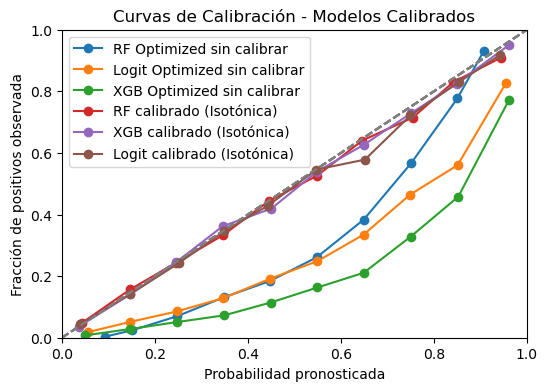

In [103]:
# Graficar curvas de calibración (diagramas de confiabilidad) para Random Forest antes y después
plt.figure(figsize=(6,4))
# Curvas de calibración antes de la calibración
metrics_utils.plot_calibration_curve(y_test, predictions['RandomForest_Optimized'][1], label="RF Optimized sin calibrar")
metrics_utils.plot_calibration_curve(y_test, predictions['LogisticRegression_Optimized'][1] , label="Logit Optimized sin calibrar")
metrics_utils.plot_calibration_curve(y_test, predictions['XGBoost_Optimized'][1], label="XGB Optimized sin calibrar")
# Curvas de calibración después de la calibración isotónica
metrics_utils.plot_calibration_curve(y_test, y_prob_rf_iso, label="RF calibrado (Isotónica)")
metrics_utils.plot_calibration_curve(y_test, y_prob_xgb_iso, label="XGB calibrado (Isotónica)")
metrics_utils.plot_calibration_curve(y_test, y_prob_logit_iso, label="Logit calibrado (Isotónica)")
plt.title("Curvas de Calibración - Modelos Calibrados")
plt.legend(loc="upper left")
plt.show()

In [97]:
# comparativo todos los modelos finales
metrics_comparison_total = pd.DataFrame(metrics_results).T
display(metrics_comparison_total)

,accuracy,precision,recall,f1,brier_score,roc_auc
Logistic,0.845383,0.714597,0.529566,0.608323,0.111504,0.865057
NaiveBayes,0.499680,0.291948,0.846620,0.434175,0.476418,0.728116
KNN,0.799167,0.594270,0.360040,0.448410,0.152113,0.745216
RandomForest,0.848861,0.746126,0.505348,0.602575,0.109042,0.875285
XGBoost,0.852887,0.741935,0.538446,0.624021,0.106220,0.880747
XGBoost_Optimized,0.737165,0.459022,0.891826,0.606090,0.179229,0.891358
RandomForest_Optimized,0.779034,0.508507,0.760040,0.609336,0.155816,0.855689
LogisticRegression_Optimized,0.786675,0.519651,0.781837,0.624335,0.149745,0.866970
RandomForest_Optimized_Calibrated_Isotonic,0.779034,0.508507,0.760040,0.609336,0.116797,0.856410
LogisticRegression_Optimized_Calibrated_Isotonic,0.786675,0.519651,0.781837,0.624335,0.111659,0.866908


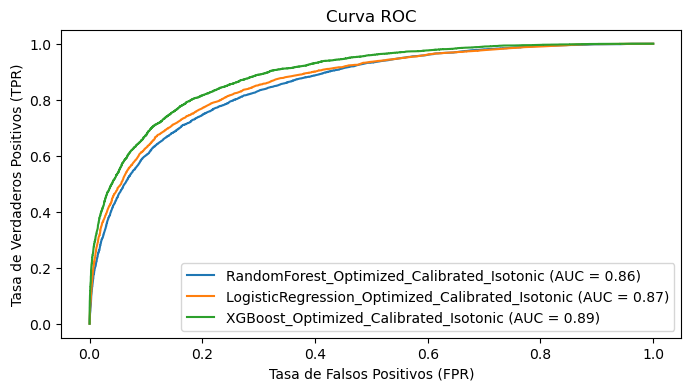

In [109]:
# ROC Curve for calibrated models
plt.figure(figsize=(8, 4))
for model_name in ['RandomForest_Optimized_Calibrated_Isotonic',
                   'LogisticRegression_Optimized_Calibrated_Isotonic',
                   'XGBoost_Optimized_Calibrated_Isotonic']:
    metrics_utils.plot_roc_curve(y_test, predictions[model_name][1], label=model_name)

Dado que hay un tradeoff entre Precision y Recall, se puede elegir el modelo que mejor se adapte a las necesidades específicas del problema.

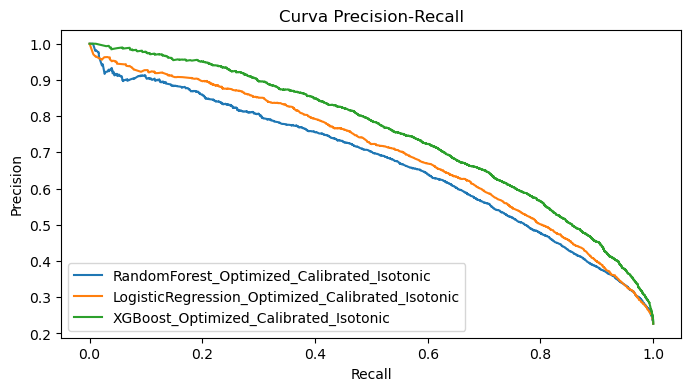

In [ ]:
# Precision-Recall Curve for calibrated models
plt.figure(figsize=(8, 4))
for model_name in ['RandomForest_Optimized_Calibrated_Isotonic',
                   'LogisticRegression_Optimized_Calibrated_Isotonic',
                   'XGBoost_Optimized_Calibrated_Isotonic']:
    metrics_utils.plot_precision_recall_curve(y_test, predictions[model_name][1], label=model_name)
plt.show()

### Conclusiones

El mejor modelo resulta ser:
* XGboost Calibrado + Optuna: 
    * ROC-AUC Score: 0.89
    * Además según las curvas de Recall-Precision para un mismo nivel de recall, tiene mejor precision